In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available and being used.")
else:
    device = torch.device("cpu")
    print("GPU not available, using CPU instead.")

GPU is available and being used.


In [3]:
# Load MNIST dataset
# Transform: first, convert image data to PyTorch tensors.
# Then, normalize the pixel values of the images. Substract the mean (0.5) from
# each pixel and divide by the standard deviation (0.5).
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
# Download the dataset to the './data' directory if not already present
# The dataset is already split, we can specify to retrieve the training or the
# testing dataset.
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.21MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.09MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.23MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
# Train data will be randomly shuffled before each epoch (= a full pass through the dataset)
# Helps prevent model from learning patterns specific to the order of data.
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
# Test data is not shuffled to achieve consistent evaluation across different runs.
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

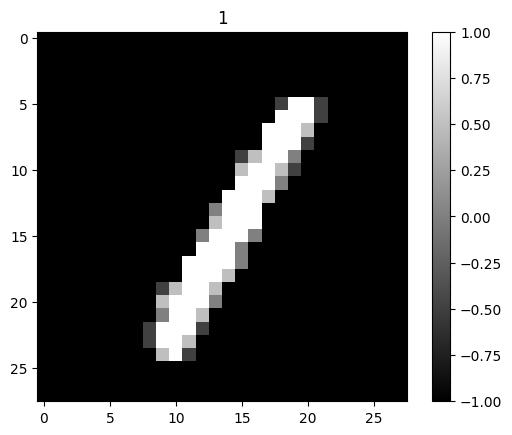

In [5]:
# Visualize an example image
image_index = 2
# Get a batch of data and their corresponding labels from the train_loader.
example_data, example_targets = next(iter(train_loader))
plt.imshow(example_data[image_index][0], cmap='gray')
plt.title(example_targets[image_index].item())
plt.colorbar()
plt.show()

In [6]:
# Define the CNN model using Sequential
model = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Flatten(),
    nn.Linear(64*7*7, 128),
    nn.ReLU(),
    nn.Linear(128, 10)  # No activation here, since CrossEntropyLoss applies log_softmax
)

In [7]:
# Move model to GPU if available
model.to(device)

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=3136, out_features=128, bias=True)
  (8): ReLU()
  (9): Linear(in_features=128, out_features=10, bias=True)
)

In [8]:
from torchsummary import summary
summary(model, (1, 28, 28), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          18,496
              ReLU-5           [-1, 64, 14, 14]               0
         MaxPool2d-6             [-1, 64, 7, 7]               0
           Flatten-7                 [-1, 3136]               0
            Linear-8                  [-1, 128]         401,536
              ReLU-9                  [-1, 128]               0
           Linear-10                   [-1, 10]           1,290
Total params: 421,642
Trainable params: 421,642
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 1.61
Estimated T

In [9]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
# Train the model
num_epochs = 10
history = {'loss': [], 'train accuracy': [], 'test accuracy': []}
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct_train = 0
    total_train = 0
    for batch_X, batch_y in train_loader:
        # Move data to GPU if available
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        y_pred = model(batch_X)
        loss = criterion(y_pred, batch_y)
        loss.backward()
        optimizer.step()

        # Estimate accuracy on the train set
        total_loss += loss.item()
        y_pred_class = torch.argmax(y_pred.data, dim=1)
        correct_train += (y_pred_class == batch_y).sum().item()
        total_train += batch_y.size(0)

    epoch_loss = total_loss / len(train_loader)
    epoch_accuracy = correct_train / total_train
    history['loss'].append(epoch_loss)
    history['train accuracy'].append(epoch_accuracy)

    # Evaluate accuracy on test set
    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            y_pred = model(batch_X)
            y_pred_class = torch.argmax(y_pred.data, dim=1)
            correct_test += (y_pred_class == batch_y).sum().item()
            total_test += batch_y.size(0)
    test_accuracy = correct_test / total_test
    history['test accuracy'].append(test_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}')


Epoch [1/10], Loss: 0.1581, Training Accuracy: 0.9520, Test Accuracy: 0.9855
Epoch [2/10], Loss: 0.0466, Training Accuracy: 0.9855, Test Accuracy: 0.9864
Epoch [3/10], Loss: 0.0320, Training Accuracy: 0.9900, Test Accuracy: 0.9840
Epoch [4/10], Loss: 0.0242, Training Accuracy: 0.9922, Test Accuracy: 0.9895
Epoch [5/10], Loss: 0.0186, Training Accuracy: 0.9940, Test Accuracy: 0.9920
Epoch [6/10], Loss: 0.0136, Training Accuracy: 0.9956, Test Accuracy: 0.9911
Epoch [7/10], Loss: 0.0120, Training Accuracy: 0.9960, Test Accuracy: 0.9912
Epoch [8/10], Loss: 0.0091, Training Accuracy: 0.9970, Test Accuracy: 0.9869
Epoch [9/10], Loss: 0.0083, Training Accuracy: 0.9973, Test Accuracy: 0.9913
Epoch [10/10], Loss: 0.0072, Training Accuracy: 0.9974, Test Accuracy: 0.9904


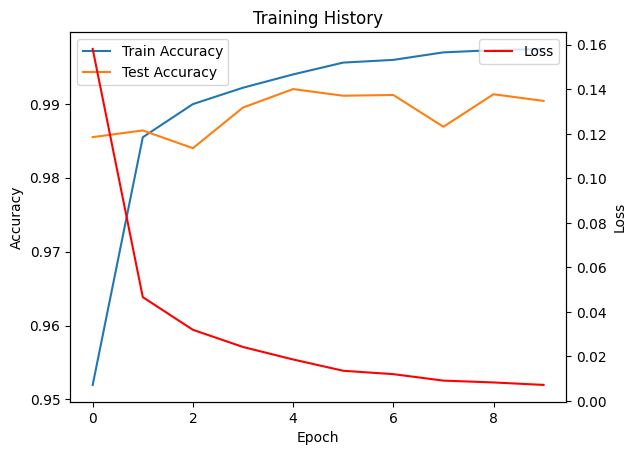

In [11]:
# Plot history
df = pd.DataFrame(history)
fig, ax1 = plt.subplots()

# Plot accuracy on the first axis
ax1.plot(df.index, df["train accuracy"], label="Train Accuracy")
ax1.plot(df.index, df["test accuracy"], label="Test Accuracy")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")
ax1.legend(loc="upper left")

# Create a second axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot loss on the second axis
ax2.plot(df.index, df["loss"], label="Loss", color="red")
ax2.set_ylabel("Loss")
ax2.legend(loc="upper right")

plt.title("Training History")
plt.show()

In [12]:
# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        y_pred = model(batch_X)
        y_pred_class = torch.argmax(y_pred.data, dim=1)
        correct += (y_pred_class == batch_y).sum().item()
        total += batch_y.size(0)

print(f'Test Accuracy: {100 * correct / total:.4f}%')

Test Accuracy: 99.0400%


In [13]:
# Predict on a few test images
example_data, example_targets = next(iter(test_loader))
y_pred = model(example_data[3:7].to(device))
y_pred_class = torch.argmax(y_pred, dim=1)
print(f"True labels: {example_targets[3:7]}")
print(f"Predicted:   {y_pred_class}")

True labels: tensor([0, 4, 1, 4])
Predicted:   tensor([0, 4, 1, 4], device='cuda:0')


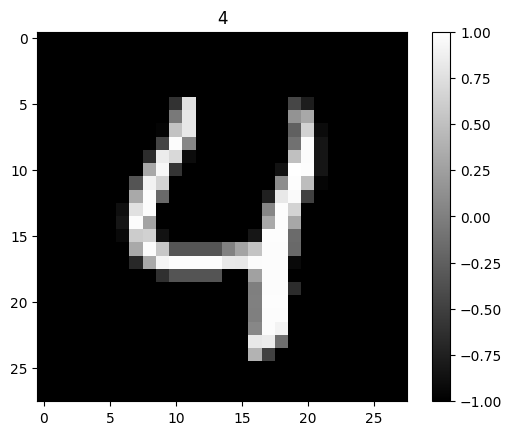

In [14]:
# Visualize a test image
image_index = 4
plt.imshow(example_data[image_index][0], cmap='gray')
plt.title(example_targets[image_index].item())
plt.colorbar()
plt.show()

# Visualizations

The following examples visualize some data on how the CNN makes decisions. For simple images like in this dataset, many are rather clear.

In [ ]:
sample_image_number = 2
image, _ = train_dataset[sample_image_number]  # Get first test image
image = image.unsqueeze(0).to(device)  # Add batch dimension

## Visualization using the external Netron software

Download from https://netron.app/

In [19]:
pip install --upgrade onnx onnxscript

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 66.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 694.9/694.9 kB 43.6 MB/s eta 0:00:00


In [20]:
import torch.onnx
# Export model to ONNX format for visualization with Netron
onnx_filename = "cnn_mnist.onnx"
# Dummy input tensor for ONNX export (batch size = 1, channels = 1, image size = 28x28)
dummy_input = torch.randn(1, 1, 28, 28).to(device)
torch.onnx.export(
    model,              # Model instance
    dummy_input,        # Example input
    onnx_filename,      # File name to save the model
    export_params=True, # Store trained parameters
    opset_version=11,   # Ensure compatibility with Netron
    do_constant_folding=True,  # Optimize the graph
    input_names=["input"],  # Define input name
    output_names=["output"], # Define output name
    dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}}  # Enable dynamic batch size
)

## Feature maps

How convolutional layers extract patterns (edges, shapes).

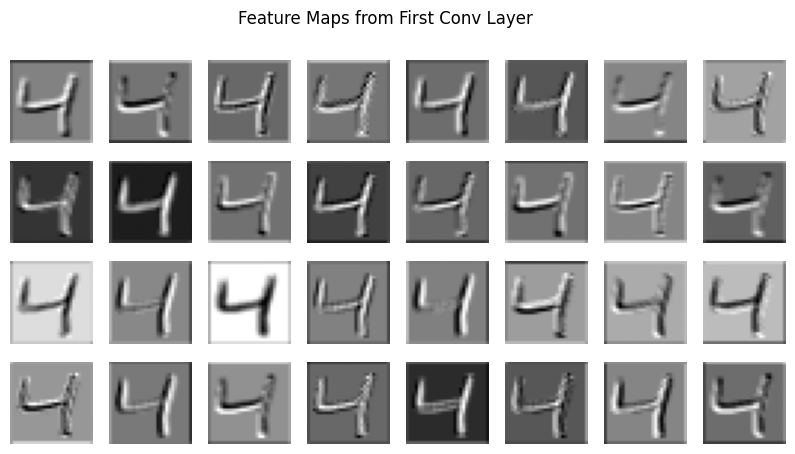

In [ ]:
# Forward pass through the first conv layer
with torch.no_grad():
    feature_maps = model[0](image)  # Extract activations from first Conv2d layer

# Plot feature maps
fig, axes = plt.subplots(4, 8, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    if i < 32:  # Number of filters in first conv layer
        ax.imshow(feature_maps[0, i].cpu().numpy(), cmap="gray")
        ax.axis("off")
plt.suptitle("Feature Maps from First Conv Layer")
plt.show()

## Saliency maps

Which pixels contribute most to classification.

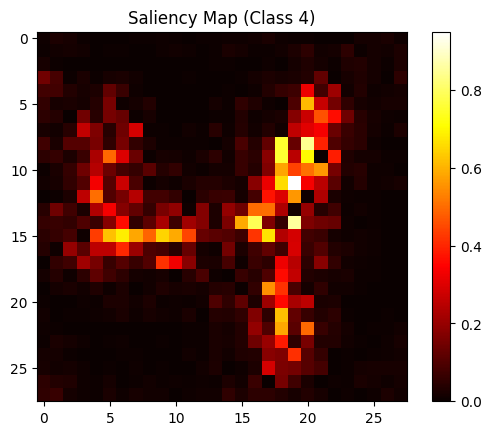

In [ ]:
model.eval()
image.requires_grad_()  # Enable gradients for input image

# Forward pass
output = model(image)
target_class = output.argmax(dim=1)  # Predicted class

# Backprop to get gradient w.r.t. input
model.zero_grad()
output[0, target_class].backward()
saliency = image.grad.abs().squeeze().cpu().numpy()

# Show saliency map
plt.imshow(saliency, cmap="hot")
plt.colorbar()
plt.title(f"Saliency Map (Class {target_class.item()})")
plt.show()

## Grad-CAM

Which regions of the image are most important for the CNN's decision. Based on the Grad-CAM paper:

R. R. Selvaraju, M. Cogswell, A. Das, R. Vedantam, D. Parikh, and D. Batra, “Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization,” <i>Int J Comput Vis</i>, vol. 128, no. 2, pp. 336–359, Feb. 2020, doi: <a href="https://doi.org/10.1007/s11263-019-01228-7">10.1007/s11263-019-01228-7</a>.

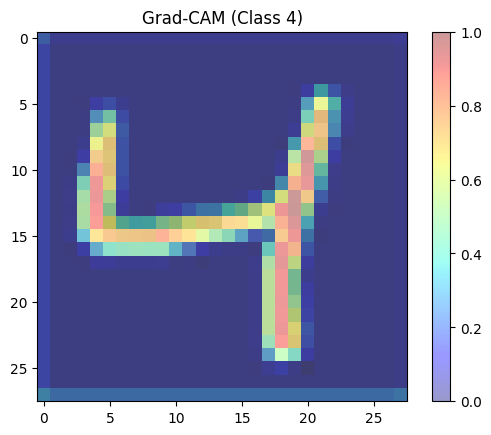

In [ ]:
# Hook to capture gradients from the last conv layer
gradients = None
def save_grad(grad):
    global gradients
    gradients = grad

# Forward pass to last conv layer
image.requires_grad_()
x = model[0](image)  # Pass through the first convolutional layer
x.register_hook(save_grad)  # Attach hook to capture gradients

# Instead of passing the flattened tensor to model[1:],
# we want to pass the output from the first conv layer (x)
# which still has the spatial dimensions
output = model[1:](x)  # Pass through rest of model

# Get prediction & compute gradients
target_class = output.argmax(dim=1)
output[0, target_class].backward()

# Generate Grad-CAM
weights = gradients.mean(dim=[2, 3], keepdim=True)  # Global average pooling
cam = (weights * feature_maps).sum(dim=1).squeeze().cpu().numpy()

# Normalize & display
cam = (cam - cam.min()) / (cam.max() - cam.min())  # Normalize
plt.imshow(image.squeeze().cpu().detach().numpy(), cmap="gray", alpha=0.6)
plt.imshow(cam, cmap="jet", alpha=0.4)  # Overlay heatmap
plt.title(f"Grad-CAM (Class {target_class.item()})")
plt.colorbar()
plt.show()